# Getting started
## An introduction to momepy

Momepy is a library for quantitative analysis of urban form - urban morphometrics. It is built on top of [GeoPandas](http://geopandas.org), [PySAL](http://pysal.org) and [networkX](http://networkx.github.io).

Some of the functionality that momepy offers:

- Measuring [dimensions](../api.rst#measuring-dimension) of morphological elements, their parts, and aggregated structures.
- Quantifying [shapes](../api.rst#measuring-shape) of geometries representing a wide range of morphological features.
- Capturing [spatial distribution](../api.rst#measuring-spatial-distribution) of elements of one kind as well as relationships between different kinds.
- Computing density and other types of [intensity](../api.rst#measuring-intensity) characters.
- Calculating [diversity](../api.rst#measuring-diversity) of various aspects of urban form.
- Capturing [connectivity](../api.rst#measuring-connectivity) of urban street networks
- Generating relational [elements](../api.rst#managing-morphological-elements) of urban form (e.g. morphological tessellation)

Momepy aims to provide a wide range of tools for a systematic and exhaustive analysis of urban form. It can work with a wide range of elements, while focused on building footprints and street networks.

## Installation

Momepy can be easily installed using conda from `conda-forge`. For detailed installation instructions, please refer to the installation documentation.

```
conda install momepy -c conda-forge
```

### Dependencies

To run all examples in this notebook, you will need `osmnx` to download data from OpenStreetMap. You can install all using the following commands:

```
conda install osmnx -c conda-forge
```

## Simple examples

Here are simple examples using embedded `bubenec` dataset (part of the Bubeneč neighborhood in Prague).

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import momepy

Morphometric analysis using momepy usually starts with GeoPandas GeoDataFrame containing morphological elements. In this case, we will begin with buildings represented by their footprints. 

We have imported `momepy`, `geopandas` to handle the spatial data, and `matplotlib` to get a bit more control over plotting. To load `bubenec` data, we need to get retrieve correct path using `momepy.datasets.get_path("bubenec")`. The dataset itself is a GeoPackage with more layers, and now we want `buildings`.

In [2]:
buildings = gpd.read_file(
    momepy.datasets.get_path("bubenec"), layer="buildings"
)

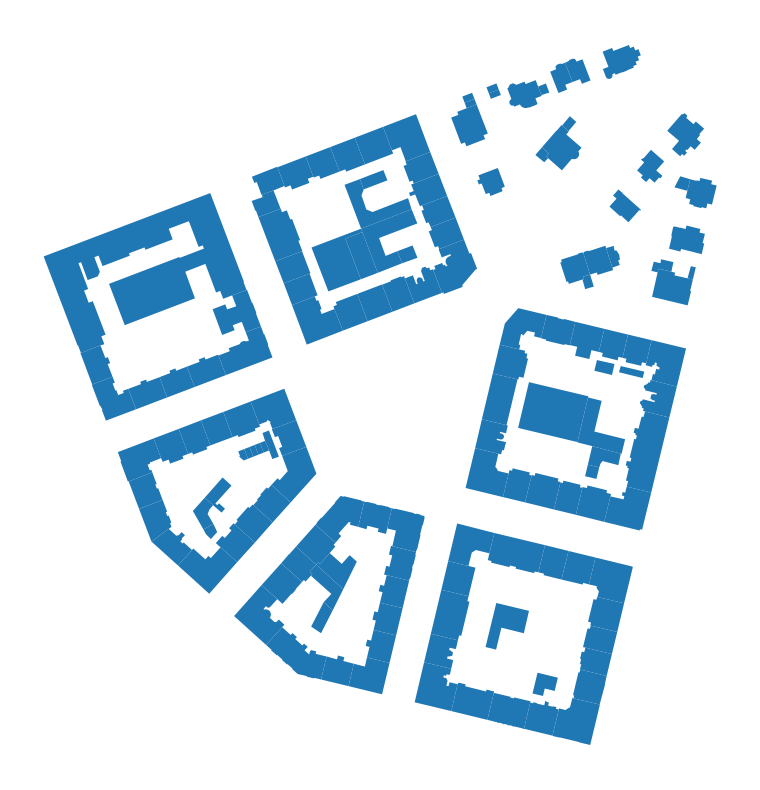

In [3]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(ax=ax)
ax.set_axis_off()
plt.show()

Momepy defines function for each measurable character. To illustrate how momepy works, we can try to measure a few simple characters.

### Equivalent rectangular index

`momepy.equivalent_rectangular_index` is an example of a morphometric character capturing the shape of each object. It can be calculated using a simple function consuimg GeoPandas object:

In [5]:
blg_eri = momepy.equivalent_rectangular_index(buildings)

/Users/martin/miniforge3/envs/momepy/lib/python3.11/site-packages/pandas/core/arraylike.py:492: RuntimeWarning: invalid value encountered in oriented_envelope
  return getattr(ufunc, method)(*new_inputs, **kwargs)


The result is a `pandas.Series`.

In [9]:
blg_eri.head()

0    0.787923
1    0.443137
2    0.954253
3    0.851658
4    0.957543
dtype: float64

In a typical worflow, you add the result as a new column of the GeoDataFrame

In [7]:
buildings["eri"] = momepy.equivalent_rectangular_index(buildings)

/Users/martin/miniforge3/envs/momepy/lib/python3.11/site-packages/pandas/core/arraylike.py:492: RuntimeWarning: invalid value encountered in oriented_envelope
  return getattr(ufunc, method)(*new_inputs, **kwargs)


Check how it looks.

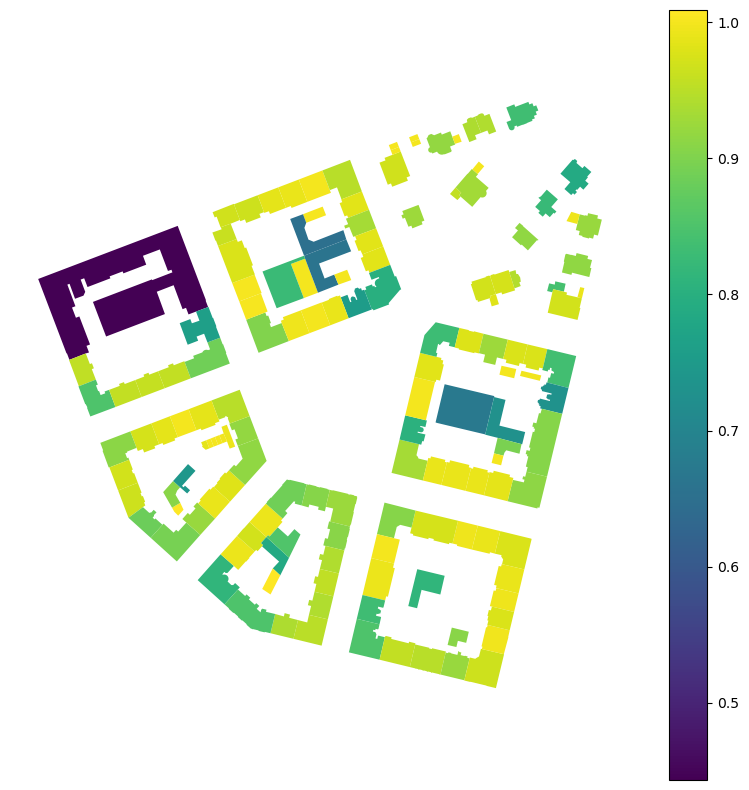

In [8]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot("eri", ax=ax, legend=True)
ax.set_axis_off()
plt.show()

## Perimeter wall length

Geometric elements are rarely considered individually. With urban fabric forming blocks like the one used here, you may be interseted in a length of the perceived perimeter wall of such a block. Note that all buildings forming the same wall share the resulting value.

In [35]:
buildings["wall_length"] = momepy.perimeter_wall(buildings)
buildings.head()

,uID,geometry,eri,wall_length
0,1,"POLYGON ((1603599.221 6464369.816, 1603602.984...",0.787923,137.186310
1,2,"POLYGON ((1603042.88 6464261.498, 1603038.961 ...",0.443137,663.342296
2,3,"POLYGON ((1603044.65 6464178.035, 1603049.192 ...",0.954253,663.342296
3,4,"POLYGON ((1603036.557 6464141.467, 1603036.969...",0.851658,663.342296
4,5,"POLYGON ((1603082.387 6464142.022, 1603081.574...",0.957543,663.342296


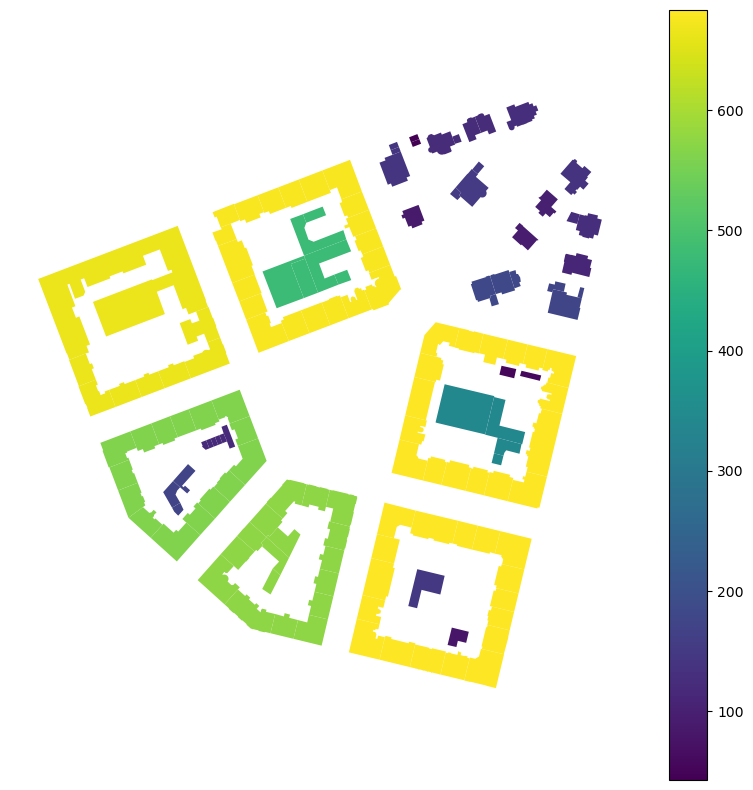

In [36]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot("wall_length", ax=ax, legend=True)
ax.set_axis_off()
plt.show()

## Capturing relation between different elements

Urban form is a complex entity that needs to be represented by multiple morphological elements, and we need to be able to describe the relationship between them. With the absence of plots for our `bubenec` case, we can use [morphological tessellation](elements/tessellation.ipynb) as the smallest spatial division.

In [33]:
tessellation = momepy.morphological_tessellation(buildings, clip=momepy.buffered_limit(buildings, buffer=50))
tessellation.head()

0    POLYGON ((1603577.153 6464348.291, 1603576.946...
1    POLYGON ((1603166.356 6464326.62, 1603166.425 ...
2    POLYGON ((1603006.941 6464167.63, 1603009.97 6...
3    POLYGON ((1602988.227 6464129.905, 1602995.269...
4    POLYGON ((1603084.231 6464104.386, 1603083.773...
dtype: geometry

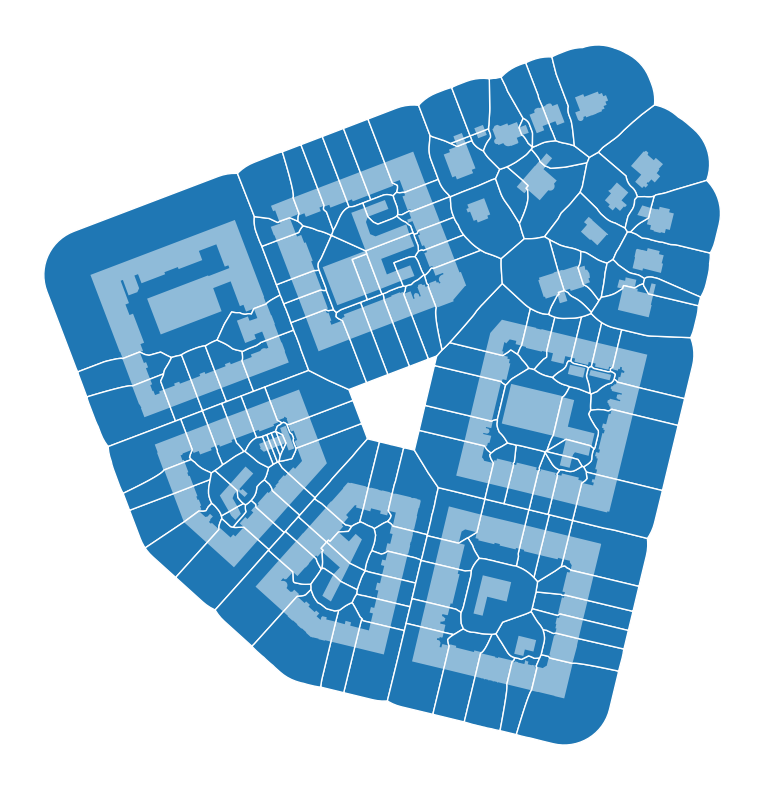

In [17]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, edgecolor="white")
buildings.plot(ax=ax, color="white", alpha=0.5)
ax.set_axis_off()
plt.show()

### Coverage area ratio

Now we can calculate how big part of each tessellation cell is covered by a related building. This is straightforward without a need for an additional function, because the two have matching index. Buildings have the same `index` as related tessellation cells, which is used to link both together (see [Data Structure](data_structure.rst)).

In [18]:
tessellation = tessellation.to_frame("geometry")
tessellation["CAR"] = buildings.area / tessellation.area

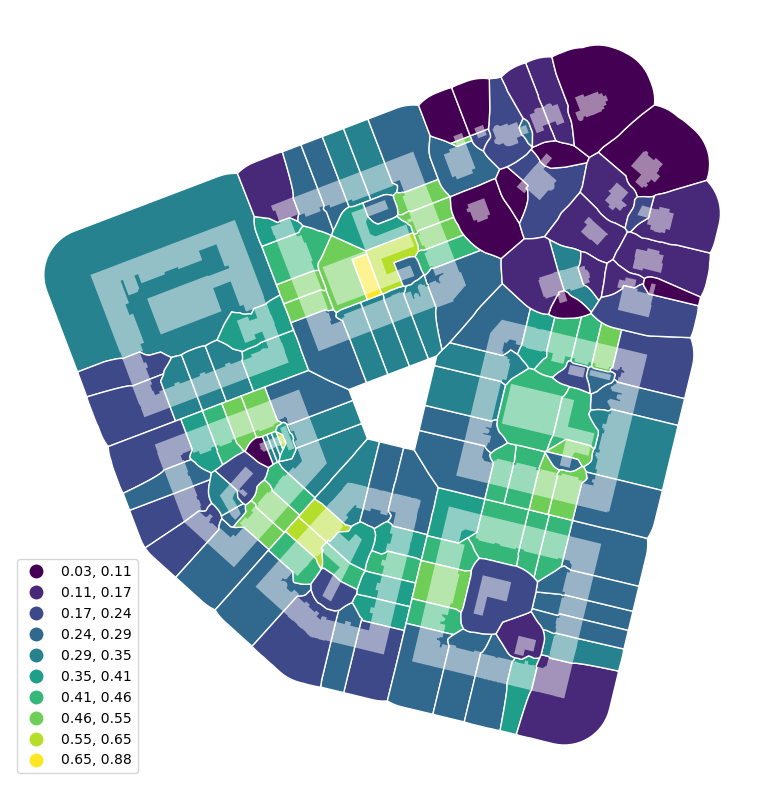

In [20]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(
    "CAR",
    ax=ax,
    edgecolor="white",
    legend=True,
    scheme="NaturalBreaks",
    k=10,
    legend_kwds={"loc": "lower left"},
)
buildings.plot(ax=ax, color="white", alpha=0.5)
ax.set_axis_off()
plt.show()

Finally, to cover the last of the essential elements, we import the street network. 

In [21]:
streets = gpd.read_file(momepy.datasets.get_path("bubenec"), layer="streets")

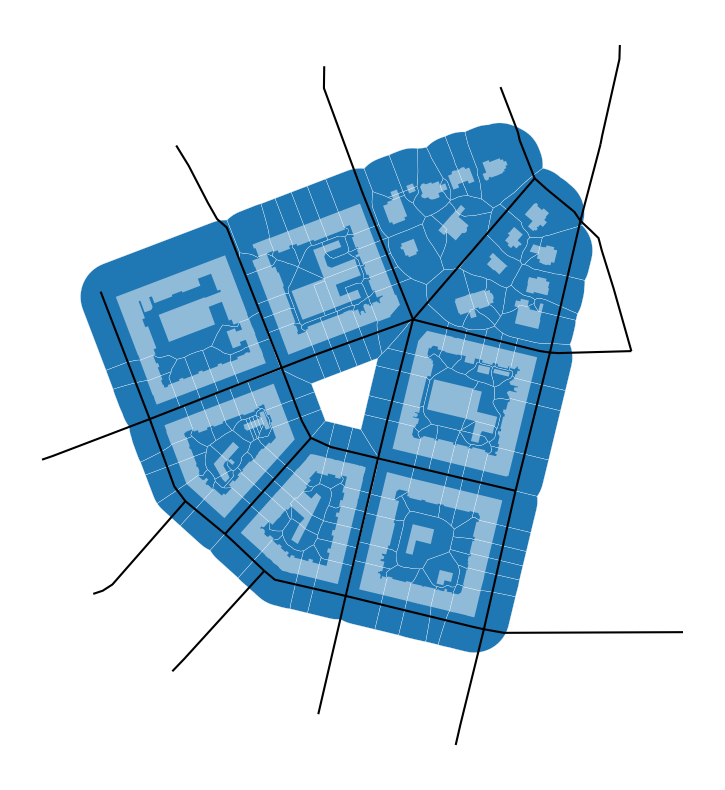

In [22]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, edgecolor="white", linewidth=0.2)
buildings.plot(ax=ax, color="white", alpha=0.5)
streets.plot(ax=ax, color="black")
ax.set_axis_off()
plt.show()

### Street profile

`momepy.street_profile` captures the relations between the segments of the street network and buildings. 

In [24]:
profile = momepy.street_profile(streets, buildings)
profile.head()

,width,openness,width_deviation
0,47.905964,0.946429,0.020420
1,42.418068,0.615385,2.644521
2,32.131831,0.608696,2.864438
3,50.000000,1.000000,NaN
4,50.000000,1.000000,NaN


We have now captured multiple characters of the street profile. As we did not specify building height (we do not know it for our data), we have widths (mean) - `profile["width"]`, standard deviation of widths (along the segment) - `profile["width_deviation"]`,  and the degree of openness - `profile["openness"]`.

In [25]:
streets["width"] = profile["width"]
streets["openness"] = profile["openness"]

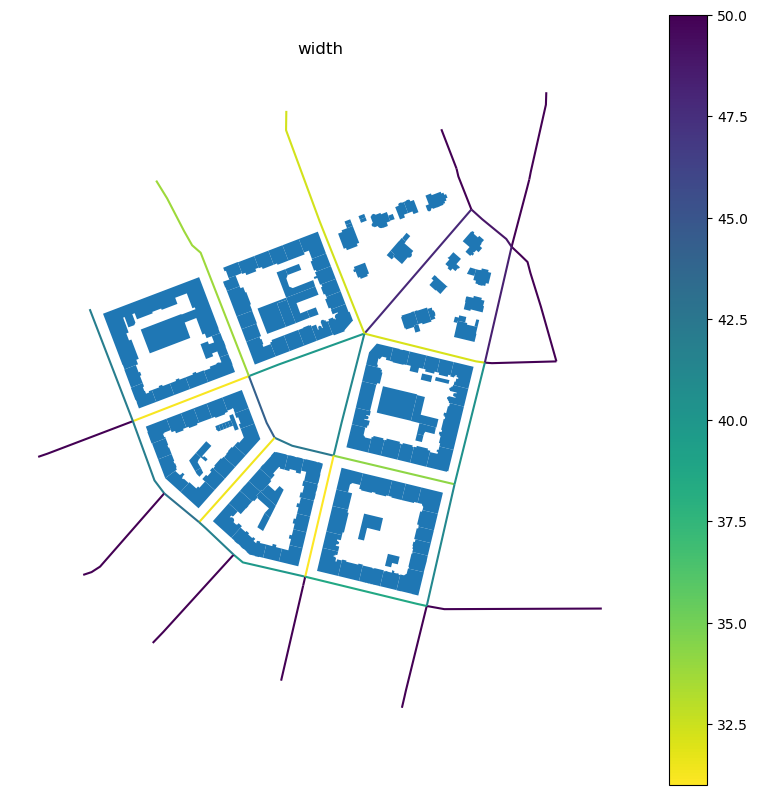

In [26]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(ax=ax)
streets.plot("width", ax=ax, legend=True, cmap="viridis_r")
ax.set_axis_off()
ax.set_title("width")
plt.show()

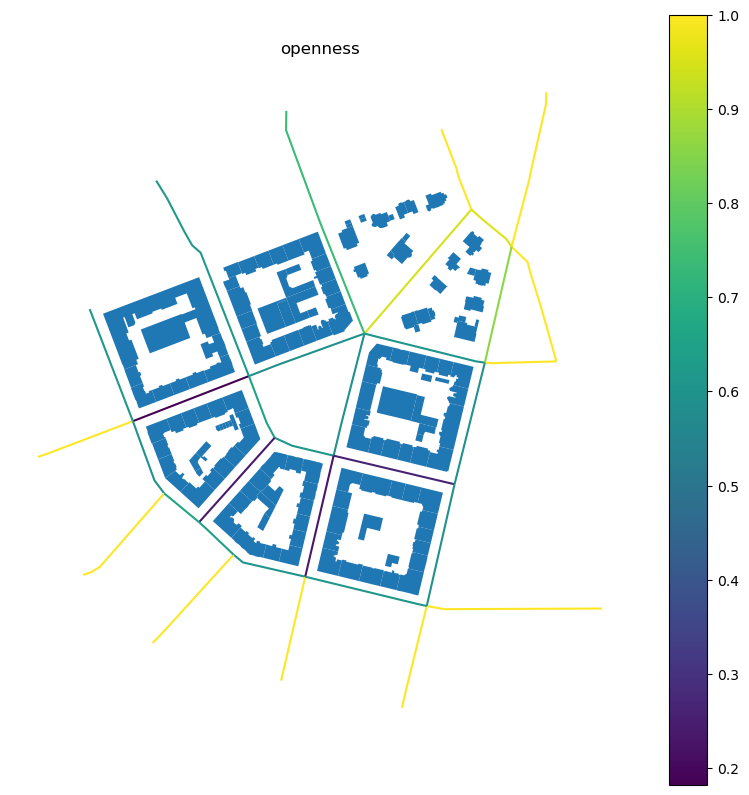

In [27]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(ax=ax)
streets.plot("openness", ax=ax, legend=True)
ax.set_axis_off()
ax.set_title("openness")
plt.show()

## Using OpenStreetMap data

In some cases (based on the completeness of OSM), we can use OpenStreetMap data without the need to save them to file and read them via GeoPandas. We can use OSMnx to retrieve them directly. In this example, we will download the building footprint of Kahla in Germany and project it to projected CRS. Momepy expects that all GeoDataFrames have the same (projected) CRS.

In [29]:
import osmnx as ox

gdf = ox.features.features_from_place(
    "Kahla, Germany", tags={"building": True}
)
gdf_projected = ox.projection.project_gdf(gdf)

/Users/martin/miniforge3/envs/momepy/lib/python3.11/site-packages/osmnx/features.py:294: FutureWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf_place["geometry"].unary_union


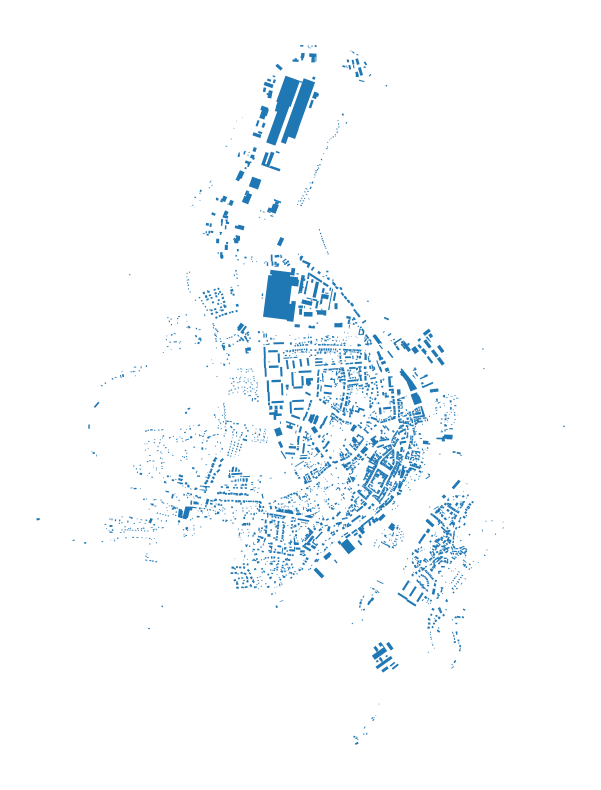

In [30]:
f, ax = plt.subplots(figsize=(10, 10))
gdf_projected.plot(ax=ax)
ax.set_axis_off()
plt.show()

Now we are in the same situation as we were above, and we can start our morphometric analysis as illustrated on the equivalent rectangular index below.

In [31]:
gdf_projected["eri"] = momepy.equivalent_rectangular_index(gdf_projected)

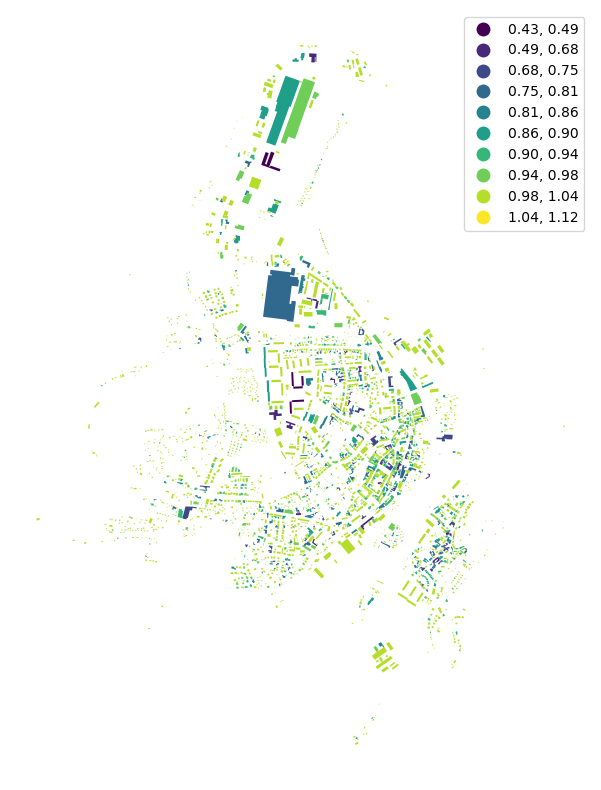

In [32]:
f, ax = plt.subplots(figsize=(10, 10))
gdf_projected.plot("eri", ax=ax, legend=True, scheme="NaturalBreaks", k=10)
ax.set_axis_off()
plt.show()

## Next steps

Now we have basic knowledge of what momepy is and how it works. It is time to [install](../install.rst) momepy (if you haven't done so yet) and browse the rest of this user guide to see more examples. Once done, head to the [API reference](../api.rst) to see the full extent of characters momepy can capture and find those you need for your research.